### 【問題1】不純度を求める関数
### 【問題2】情報利得を求める関数
### 【問題3】学習
### 【問題4】推定
### 【問題5】学習と推定
### 【問題6】決定領域の可視化

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
pd.set_option('display.expand_frame_repr', False)


class DecisionTreeNode(object):
    def __init__(self, data, target, max_depth):
        self.left = None            # 子ノードのオブジェクトが格納されていく
        self.right = None           # 子ノードのオブジェクトが格納されていく
        self.max_depth = max_depth
        self.depth = None
        self.data = data
        self.target = target
        self.threshold = None
        self.feature = None
        self.gini_min = None
        self.label = np.argmax(np.bincount(target))

    # ノードに対応するDecisionTreeNodeの子オブジェクトを再帰的に生成
    def split(self, depth):
        self.depth = depth
        self.gini_min, self.threshold, self.feature = self._search_best_split(self.data, self.target)
        # print('Depth: {}, Sep at Feature: {},Threshold: {}, Label: {}'.format(self.depth, self.feature, self.threshold,
        #                                                                       self.label))

        if self.depth == self.max_depth or self.gini_min == 0:
            return
        idx_left = self.data[:, self.feature] >= self.threshold
        idx_right = self.data[:, self.feature] < self.threshold

        self.left = DecisionTreeNode(self.data[idx_left], self.target[idx_left], self.max_depth)
        self.right = DecisionTreeNode(self.data[idx_right], self.target[idx_right], self.max_depth)
        self.left.split(self.depth + 1)
        self.right.split(self.depth + 1)

    # search_best_splitで求めた最適な説明変数と閾値が格納されているためこれを使用します
    # 先ほどの停止条件と同様に、Gini係数が0または深さがmax_depthに達した場合は末端ノード（葉ノード）となるため、ここでラベルを返す
    # これはノードに含まれているサンプルのうち最も多いクラスを返しており、これが予測ラベルとなる
    # 葉ノードに達していない場合は、閾値に従って分岐を進んでいき、末端に達した時点で予測ラベルを返すという実装
    def predict(self, data):
        if self.gini_min == 0.0 or self.depth == self.max_depth:
            return self.label
        else:
            # print(f"self.feature: {self.feature} len(data): {len(data)} data: {data} data[self.feature]: {data[self.feature]} self.threshold:{self.threshold}")
            if data[self.feature] > self.threshold:
                return self.left.predict(data)
            else:
                return self.right.predict(data)

    # ノードを分割する最適な説明変数と閾値の選択
    def _search_best_split(self, data, target):
        features = data.shape[1]
        best_thrs = None
        best_f = None
        # gini = None
        gini_min = 1

        for feat_idx in range(features):
            values = data[:, feat_idx]
            for val in values:
                gini = self._gini_score(data, target, feat_idx, val)
                if gini_min > gini:
                    gini_min = gini
                    best_thrs = val
                    best_f = feat_idx
        return gini_min, best_thrs, best_f

    # Gini係数を求める関数
    @staticmethod
    def _gini_score(data, target, feat_idx, threshold):
        gini = 0
        sample_num = len(target)

        div_target = [target[data[:, feat_idx] >= threshold], target[data[:, feat_idx] < threshold]]

        for group in div_target:
            score = 0
            classes = np.unique(group)
            for cls in classes:
                p = np.sum(group == cls) / len(group)
                score += p * p
            gini += (1 - score) * (len(group) / sample_num)
        return gini


class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, data, target):
        initial_depth = 0
        self.tree = DecisionTreeNode(data, target, self.max_depth)
        self.tree.split(initial_depth)

    def predict(self, data):
        pred = []
        for s in data:
            pred.append(self.tree.predict(s))
        return np.array(pred)


def decision_region2(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel',
                     target_names=('setosa', 'versicolor', 'virginica')):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import matplotlib.patches as mpatches
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['green', 'red', 'blue']
    contourf_color = ['lime', 'pink', 'skyblue']
    n_class = 3  # yの種類数(クラス数)

    #
    # 2つの特徴量のmin/maxレンジから細かい単位で、すべての組み合わせのpredictを行い、それを背景色として決定境界を描く
    #
    # 特徴量2つのメッシュグリッドを作成
    # mesh_f0, mesh_f1 ともに2次元配列
    # 参考: https://deepage.net/features/numpy-meshgrid.html
    x0_min = np.min(X[:, 0])
    x0_max = np.max(X[:, 0])
    x1_min = np.min(X[:, 1])
    x1_max = np.max(X[:, 1])
    x0_range = np.arange(x0_min - 0.5, x0_max + 0.5, step)  # sepal_length
    x1_range = np.arange(x1_min - 0.5, x1_max + 0.5, step)  # petal_length
    mesh_f0, mesh_f1 = np.meshgrid(x0_range, x1_range)
    # 学習用に配列の形状変換
    # ravel: 2次元配列を1次元配列にする
    # c_: 各indexの同じ要素で1つの配列とし、2次元配列を作る
    # 実質座標を表すようになる？
    # len(mesh) = 172260
    mesh = np.c_[np.ravel(mesh_f0), np.ravel(mesh_f1)]
    # おそらく、特徴量の組み合わせを膨大に作って、予測値を算出している
    # mesh_f0.shape: (396, 435)
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # contourf(格子点のx座標の配列, 格子点のy座標の配列, 値の配列)
    # contourf([X, Y,] Z, [levels], **kwargs)
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html
    # エリアの色塗り
    plt.contourf(mesh_f0, mesh_f1, y_pred, levels=n_class - 1, cmap=ListedColormap(contourf_color))
    # 　境界線の強調
    plt.contour(mesh_f0, mesh_f1, y_pred, levels=n_class - 1, colors='y', linewidths=3, alpha=0.5)

    #
    # 引数のx,yを単純にplotする
    #
    unique_y = set(y)  # 0, 1, 2
    for i, target in enumerate(unique_y):  # enumerate: idxとvalueを使える
        tgt_color = scatter_color[i]
        tgt_label = target_names[i]
        a = X[y == target][:, 0]  # sepal_length
        b = X[y == target][:, 1]  # petal_length
        plt.scatter(a, b, s=80, color=tgt_color, label=tgt_label, marker='o')
    # 凡例表示
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)  # これだけだとバーで表示される
    plt.legend()  # これを呼ぶと丸になる 謎
    plt.show()

pred :[1 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 2 1 2 1 1 2 1 2 1]
Classification accuracy: 0.92


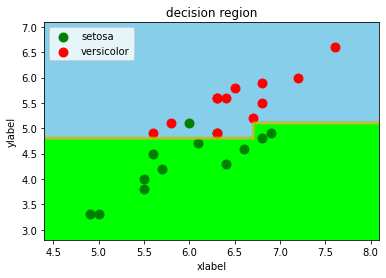

pred :[1 2 1 2 2 2 1 2 2 2 2 2 2 1 2 1 2 1 2 1 1 2 1 2 1]
Classification accuracy: 0.88


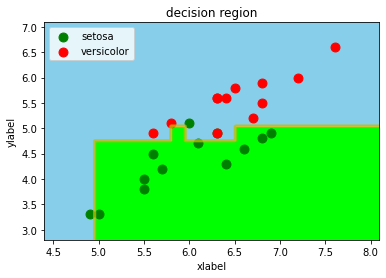

In [2]:
# 自作クラスによる学習/推定
def main1(x_train, x_test, y_train, y_test):
    clf = DecisionTreeClassifier(max_depth=3)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(f"pred :{y_pred}")
    score = sum(y_pred == y_test) / float(len(y_test))
    print('Classification accuracy: {}'.format(score))
    decision_region2(x_test, y_test, clf)


# def main2():
#     iris = load_iris()
#     data = iris.data
#     target = iris.target
#     x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)
#
#     clf = DecisionTreeClassifier(max_depth=3)
#     clf.fit(x_train, y_train)
#     y_pred = clf.predict(x_test)
#     score = sum(y_pred == y_test) / float(len(y_test))
#     print('Classification accuracy: {}'.format(score))


# sklearnのDecisionTreeClassifierによる学習/推定
def main3(x_train, x_test, y_train, y_test):
    from sklearn.tree import DecisionTreeClassifier
    dtc = DecisionTreeClassifier()
    dtc.fit(x_train, y_train)
    y_pred = dtc.predict(x_test)
    print(f"pred :{y_pred}")
    score = sum(y_pred == y_test) / float(len(y_test))
    print('Classification accuracy: {}'.format(score))
    decision_region2(x_test, y_test, dtc)


if __name__ == '__main__':
    # データの前準備
    iris = load_iris()
    x = pd.DataFrame(iris.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
    x = x.loc[:, ["sepal_length", "petal_length"]]
    y = pd.Series(iris.target, name="y")
    df_train = x.join(y).query('y in (1,2)')
    x = df_train.drop(["y"], axis=1)
    y = df_train["y"]
    x_train2, x_test2, y_train2, y_test2 = train_test_split(x.values, y.values, test_size=0.25, shuffle=True, random_state=0)
    main1(x_train2, x_test2, y_train2, y_test2)
    main3(x_train2, x_test2, y_train2, y_test2)